In [ ]:
!pip install pysal --quiet
!pip install unidecode --quiet
!pip install fuzzywuzzy --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 k

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
from libpysal.weights import Queen
from esda import Moran, Moran_Local, Geary, G
import matplotlib.pyplot as plt
from libpysal import weights
from splot.esda import moran_scatterplot
from sklearn.preprocessing import StandardScaler
from spreg import ML_Lag, ML_Error
from scipy.stats import normaltest, levene
import unidecode
from fuzzywuzzy import process
import warnings
from scipy.stats import f

# Model z projektu 3

In [ ]:
data = pd.ExcelFile('daneProj3.xlsx')
df = data.parse('Arkusz1')

# Normalizacja nazw w daneProj3
df['Nazwa'] = df['Nazwa'].str.replace('Powiat ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.replace('m. ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.replace('st. ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.strip().str.lower()

# Usuwanie duplikatów
df = df.drop_duplicates(subset='Nazwa')

# Definicja zmiennej zależnej i objaśniających
X = df.drop(columns=['odpadyTysTon', 'Nazwa'], errors='ignore')  # Usuwamy 'Nazwa', jeśli istnieje
y = df['odpadyTysTon']

# Dodanie stałej do modelu
X = sm.add_constant(X)

# Budowa modelu OLS
model_filtered = sm.OLS(y, X).fit()
print(model_filtered.summary())

# Pobieranie reszt
residuals = model_filtered.resid


                            OLS Regression Results                            
Dep. Variable:           odpadyTysTon   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.3853
Date:                Sat, 21 Dec 2024   Prob (F-statistic):              0.888
Time:                        15:58:10   Log-Likelihood:                -1999.6
No. Observations:                 370   AIC:                             4013.
Df Residuals:                     363   BIC:                             4041.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 49.6302     28

# Badanie zależności przestrzennych w modelu

In [ ]:
powiaty = gpd.read_file('powiaty.shp')
powiaty['geometry'] = powiaty['geometry'].buffer(0)


In [ ]:
df = data.parse('Arkusz1')
df.head()

,Nazwa,gestoscZaludnienia,ludnoscTys,wskUrban,turystyka,wynagrodzenie,bezrobocie,odpadyTysTon
0,Powiat bolesławiecki,67.5,87.92,47.1,17,6181.60,3.1,10.56
1,Powiat dzierżoniowski,200.3,95.86,78.2,19,5723.65,5.2,59.76
2,Powiat głogowski,193.3,85.69,73.4,9,5856.76,6.4,17.89
3,Powiat górowski,44.3,32.74,41.1,1,5423.11,13.8,25.50
4,Powiat jaworski,81.9,47.58,53.6,14,6142.84,10.2,31.36


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Nazwa               380 non-null    object 
 1   gestoscZaludnienia  380 non-null    float64
 2   ludnoscTys          380 non-null    float64
 3   wskUrban            380 non-null    float64
 4   turystyka           380 non-null    int64  
 5   wynagrodzenie       380 non-null    float64
 6   bezrobocie          380 non-null    float64
 7   odpadyTysTon        380 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
# Normalizacja nazw w powiaty.shp
powiaty['JPT_NAZWA_'] = powiaty['JPT_NAZWA_'].str.replace('powiat ', '', regex=False)
powiaty['JPT_NAZWA_'] = powiaty['JPT_NAZWA_'].str.strip().str.lower()

# Normalizacja nazw w daneProj3.xlsx
df['Nazwa'] = df['Nazwa'].str.replace('Powiat ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.replace('m. ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.replace('st. ', '', regex=False)
df['Nazwa'] = df['Nazwa'].str.strip().str.lower()


W celu stworzenia macierzy odleglosci potrzebujemy miec kolumne Nazwa w df, dlatego teraz powtorzymy kroki ktore byly wykonane w procesie tworzenia modelu liniowego, aby miec taki sam dataframe tylko z dodatkowa kolumna

In [ ]:
# Dodanie reszt do DataFrame na podstawie indeksu
df['residuals'] = model_filtered.resid
df['residuals'] = df['residuals'].fillna(df['residuals'].mean())

# Połączenie danych przestrzennych z resztami na podstawie 'Nazwa'
powiaty2 = powiaty.merge(df, left_on='JPT_NAZWA_', right_on='Nazwa', how='inner')

# Usunięcie duplikatów w powiaty2
powiaty2 = powiaty2.drop_duplicates(subset='JPT_NAZWA_').reset_index(drop=True)

# Dopasowanie reszt do kolejności powiaty2
residuals_aligned = powiaty2['residuals']


In [ ]:
# 4. Tworzenie macierzy wag przestrzennych Queen
w = Queen.from_dataframe(powiaty2)
w.transform = 'R'

<ipython-input-109-dcecf96ba24d>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(powiaty2)


In [ ]:
 #5 . Obliczanie wskaźników przestrzennych dla reszt modelu OLS

# a. Moran's I dla reszt
moran_residuals = Moran(residuals, w, permutations=999)
print('Wskaźnik Moran\'a I dla reszt:', moran_residuals.I)
print('p-value (permutacje) dla reszt:', moran_residuals.p_sim)
print('Z-score (permutacje) dla reszt:', moran_residuals.z_sim)

# b. Geary's C dla reszt
geary_residuals = Geary(residuals, w, permutations=999)
print("Geary's C dla reszt:", geary_residuals.C)
print("Geary's C p-value (permutacje) dla reszt:", geary_residuals.p_sim)

# c. Getis-Ord G dla reszt
getis_ord_residuals = G(residuals, w, permutations=999)
print("Getis-Ord G dla reszt:", getis_ord_residuals.G)
print("Getis-Ord G p-value (permutacje) dla reszt:", getis_ord_residuals.p_sim)


Wskaźnik Moran'a I dla reszt: -0.053119854099342965
p-value (permutacje) dla reszt: 0.01
Z-score (permutacje) dla reszt: -1.8107841838551764
Geary's C dla reszt: 1.2686023159804458
Geary's C p-value (permutacje) dla reszt: 0.057
Getis-Ord G dla reszt: 0.191680924476207
Getis-Ord G p-value (permutacje) dla reszt: 0.051


/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 109 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


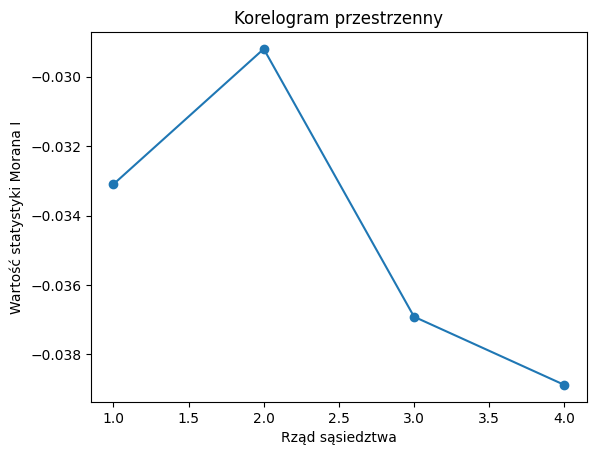

In [ ]:
# 8. Korelogram przestrzenny
lags = range(1, 5)
moran_stats = []

for lag in lags:
    w_lag = weights.KNN.from_dataframe(powiaty2, k=lag)
    w_lag.transform = 'R'
    moran_lag = Moran(residuals, w_lag, permutations=999)
    moran_stats.append(moran_lag.I)

plt.plot(lags, moran_stats, marker='o')
plt.title('Korelogram przestrzenny')
plt.xlabel('Rząd sąsiedztwa')
plt.ylabel('Wartość statystyki Morana I')
plt.show()

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:131: UserWarning: `p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects
  warnings.warn(


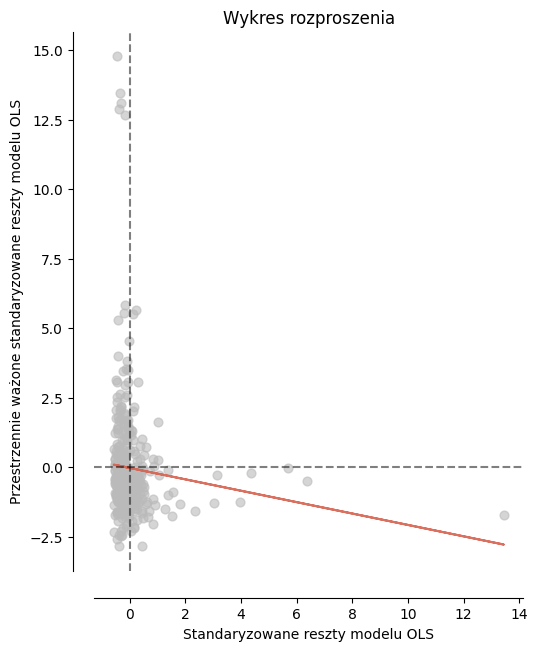

In [ ]:
# 9. Wykres rozproszenia
fig, ax = moran_scatterplot(moran_perm, p=0.05)
ax.set_xlabel('Standaryzowane reszty modelu OLS')
ax.set_ylabel('Przestrzennie ważone standaryzowane reszty modelu OLS')
plt.title('Wykres rozproszenia')
plt.show()

# modele SAR i SEM

In [ ]:
# przygotowanie danych do uzycia w modelach SAR, SEM
columns_to_drop = ['gml_id', 'JPT_ORGAN_', 'JPT_KOD__1', 'JPT_NAZWA1', 'JPT_KJ_I_2', 'JPT_OPIS', 'JPT_KJ_I_3']
powiaty2 = powiaty2.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
X_aligned = powiaty2.drop(columns=['odpadyTysTon', 'Nazwa', 'residuals'], errors='ignore')
X_aligned = X_aligned.select_dtypes(include=[np.number])

y_aligned = powiaty2['odpadyTysTon']

In [ ]:
# Model SAR
sar_model = ML_Lag(y_aligned.values, X_aligned.values, w, name_y='odpadyTysTon', name_x=list(X_aligned.columns))
print(sar_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :odpadyTysTon                Number of Observations:         370
Mean dependent var  :     35.6035                Number of Variables   :           8
S.D. dependent var  :     54.0573                Degrees of Freedom    :         362
Pseudo R-squared    :      0.0071
Spatial Pseudo R-squared:  0.0060
Log likelihood      :  -1999.5482
Sigma-square ML     :   2893.5822                Akaike info criterion :    4015.096
S.E of regression   :     53.7920                Schwarz criterion     :    4046.404

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/spreg/ml_lag.py:683: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [ ]:
# Model SEM
sem_model = ML_Error(y_aligned.values, X_aligned.values, w, name_y='odpadyTysTon', name_x=list(X_aligned.columns))
print("Model SEM:")
print(sem_model.summary)


Model SEM:
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :odpadyTysTon                Number of Observations:         370
Mean dependent var  :     35.6035                Number of Variables   :           7
S.D. dependent var  :     54.0573                Degrees of Freedom    :         363
Pseudo R-squared    :      0.0063
Log likelihood      :  -1999.4525
Sigma-square ML     :   2891.1733                Akaike info criterion :    4012.905
S.E of regression   :     53.7696                Schwarz criterion     :    4040.300

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        4

/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:543: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [ ]:
# Porównanie modeli
print("Model OLS: AIC =", model_filtered.aic)
print("Model SAR: AIC =", sar_model.aic)
print("Model SEM: AIC =", sem_model.aic)

Model OLS: AIC = 4013.297886740655
Model SAR: AIC = 4015.0964737687586
Model SEM: AIC = 4012.905083668475


## **Cel analizy**
Sprawdzenie, czy modele SAR (Spatial Autoregressive Model) i SEM (Spatial Error Model) wnoszą istotne ulepszenie w porównaniu z modelem OLS.

---

## **Kryteria porównania**
1. **AIC (Akaike Information Criterion)**:
   - Niższa wartość AIC oznacza lepsze dopasowanie modelu przy uwzględnieniu liczby parametrów.

---

## **Wyniki porównania**
| Model      | AIC        |
|------------|------------|
| **OLS**    | 4013.30    |
| **SAR**    | 4015.10    |
| **SEM**    | 4012.91    |

---

## **Interpretacja wyników**
1. **Model SAR**:
   - Wartość AIC dla SAR (4015.10) jest wyższa niż dla OLS (4013.30), co wskazuje, że model SAR nie poprawia dopasowania w porównaniu do OLS.
   - Wyższa wartość AIC oznacza, że model SAR nie jest uzasadniony w tym przypadku.

2. **Model SEM**:
   - Wartość AIC dla SEM (4012.91) jest minimalnie niższa niż dla OLS (4013.30), co sugeruje, że model SEM może być nieznacznie lepszy od OLS.
   - Różnica AIC jest jednak bardzo mała, co może wskazywać na brak istotnych korzyści z wprowadzenia SEM.

---

## **Wniosek**
- Model SAR nie wnosi poprawy w stosunku do OLS, co sugeruje, że w tym przypadku nie ma sensu go wprowadzać.
- Model SEM jest minimalnie lepszy od OLS, ale różnica w wartościach AIC jest bardzo mała



In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Podział danych na części
split_index = len(X_aligned) // 2
X_part1, X_part2 = X_aligned.iloc[:split_index], X_aligned.iloc[split_index:]
y_part1, y_part2 = y_aligned.iloc[:split_index], y_aligned.iloc[split_index:]

# Tworzenie nowych macierzy wag dla podzbiorów
powiaty_part1 = powiaty2.iloc[:split_index]
powiaty_part2 = powiaty2.iloc[split_index:]

w_part1 = Queen.from_dataframe(powiaty_part1, use_index=False)
w_part1.transform = 'B'

w_part2 = Queen.from_dataframe(powiaty_part2, use_index=False)
w_part2.transform = 'B'

# Model SAR dla części danych
sar_part1 = ML_Lag(y_part1.values, X_part1.values, w_part1, name_y='odpadyTysTon', name_x=list(X_part1.columns))
sar_part2 = ML_Lag(y_part2.values, X_part2.values, w_part2, name_y='odpadyTysTon', name_x=list(X_part2.columns))

RSS_sar_full = np.sum(sar_model.u ** 2)
RSS_sar_part1 = np.sum(sar_part1.u ** 2)
RSS_sar_part2 = np.sum(sar_part2.u ** 2)

F_chow_sar = ((RSS_sar_full - (RSS_sar_part1 + RSS_sar_part2)) / len(X_aligned.columns)) / \
             ((RSS_sar_part1 + RSS_sar_part2) / (len(y_aligned) - 2 * len(X_aligned.columns)))
df_num = len(X_aligned.columns)  # Liczba parametrów
df_den = len(y_aligned) - 2 * len(X_aligned.columns)  # Liczba stopni swobody
p_value_sar = 1 - f.cdf(F_chow_sar, df_num, df_den)

# Wynik dla SAR
print(f"Statystyka testu Chowa (SAR): {F_chow_sar:.4f}, p-value: {p_value_sar:.4f}")

# Test Chowa dla SEM
sem_part1 = ML_Error(y_part1.values.reshape(-1, 1), X_part1.values, w_part1, name_y='odpadyTysTon', name_x=list(X_part1.columns))
sem_part2 = ML_Error(y_part2.values.reshape(-1, 1), X_part2.values, w_part2, name_y='odpadyTysTon', name_x=list(X_part2.columns))

RSS_sem_full = np.sum(sem_model.u ** 2)
RSS_sem_part1 = np.sum(sem_part1.u ** 2)
RSS_sem_part2 = np.sum(sem_part2.u ** 2)

F_chow_sem = ((RSS_sem_full - (RSS_sem_part1 + RSS_sem_part2)) / len(X_aligned.columns)) / \
             ((RSS_sem_part1 + RSS_sem_part2) / (len(y_aligned) - 2 * len(X_aligned.columns)))
p_value_sem = 1 - f.cdf(F_chow_sem, df_num, df_den)

# Wynik dla SEM
print(f"Statystyka testu Chowa (SEM): {F_chow_sem:.4f}, p-value: {p_value_sem:.4f}")

Statystyka testu Chowa (SAR): 1.3524, p-value: 0.2331
Statystyka testu Chowa (SEM): 1.0343, p-value: 0.4026


**Test Chowa (Stabilność parametrów)**

### Hipotezy:
- **H₀**: Parametry modelu są stabilne w obu podzbiorach danych (brak różnic między grupami).
- **H₁**: Parametry modelu różnią się między podzbiorami danych (model nie jest stabilny w obu grupach).

### Wyniki:
- **Statystyka testu Chowa (SAR)**: \( F = 1.3524 \), \( p-value = 0.2331 \)
- **Statystyka testu Chowa (SEM)**: \( F = 1.0343 \), \( p-value = 0.4026 \)

### Interpretacja:
- Dla obu modeli p-value > 0,5, co oznacza brak podstaw do odrzucenia hipotezy zerowej.
- Parametry modeli SAR i SEM są stabilne między podzbiorami danych, co świadczy o ich poprawnej specyfikacji i braku istotnych różnic między grupami.

---

In [ ]:
# 13. Testy heteroskedastyczności
from scipy.stats import levene

# Podział reszt SAR na dwie grupy
mid_index = len(sar_model.u) // 2
group1_sar = sar_model.u[:mid_index]
group2_sar = sar_model.u[mid_index:]

# Test Levene'a dla SAR
levene_sar = levene(group1_sar, group2_sar)
print("Levene SAR : p-value:", levene_sar.pvalue)

# Podział reszt SEM na dwie grupy
mid_index = len(sem_model.u) // 2
group1_sem = sem_model.u[:mid_index]
group2_sem = sem_model.u[mid_index:]

# Test Levene'a dla SEM
levene_sem = levene(group1_sem, group2_sem)
print("Levene SEM: p-value:", levene_sem.pvalue)


Levene SAR : p-value: [0.6311837]
Levene SEM: p-value: [0.62188341]


 **Test Levene'a (Homoskedastyczność)**

### Hipotezy:
- **H₀**: Wariancje reszt modelu są równe we wszystkich porównywanych grupach (homoskedastyczność).
- **H₁**: Wariancje reszt modelu nie są równe w co najmniej dwóch grupach (heteroskedastyczność).

### Wyniki:
- **Levene SAR**: \( p-value = 0.6312 \)
- **Levene SEM**: \( p-value = 0.6219 \)

### Interpretacja:
- Dla obu modeli p-value > 0.05, co oznacza brak podstaw do odrzucenia hipotezy zerowej.
- Możemy przyjąć, że wariancje reszt modelu SAR i SEM są jednorodne (brak heteroskedastyczności).


In [ ]:
# 14. Test normalności reszt
normality_sar = normaltest(sar_model.u)
normality_sem = normaltest(sem_model.u)
print("Normalność reszt SAR: p-value:", normality_sar.pvalue)
print("Normalność reszt SEM: p-value:", normality_sem.pvalue)

Normalność reszt SAR: p-value: [3.28192338e-126]
Normalność reszt SEM: p-value: [3.27644857e-126]


## **Cel testu**
Sprawdzenie, czy reszty modeli SAR i SEM są zgodne z rozkładem normalnym. Normalność reszt jest istotnym założeniem dla poprawnej specyfikacji modelu i interpretacji wyników.

---

## **Hipotezy**
- **H₀**: Reszty modelu pochodzą z rozkładu normalnego.
- **H₁**: Reszty modelu nie pochodzą z rozkładu normalnego.

---

## **Wyniki testu**
- **Normalność reszt SAR**: p-value = 3.2819 * 10^-126
- **Normalność reszt SEM**: p-value = 3.2764 * 10^-126

P-value bardzo bliskie zera, najprawdopodobniej może byc to powiązane z występowaniem wartości odstających. Dodatkowo dane mogą zawierać zależności nieliniowe nieuwzględnione w modelu.

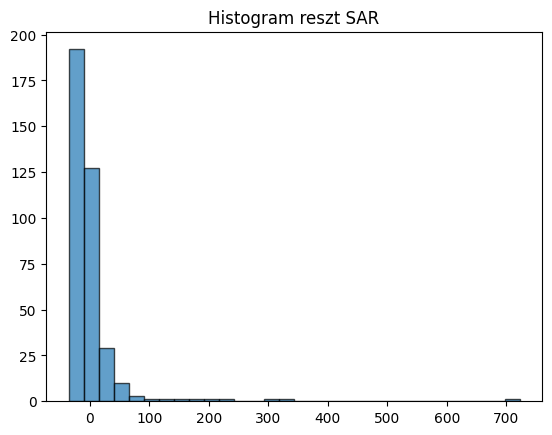

In [ ]:
plt.hist(sar_model.u, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram reszt SAR')
plt.show()


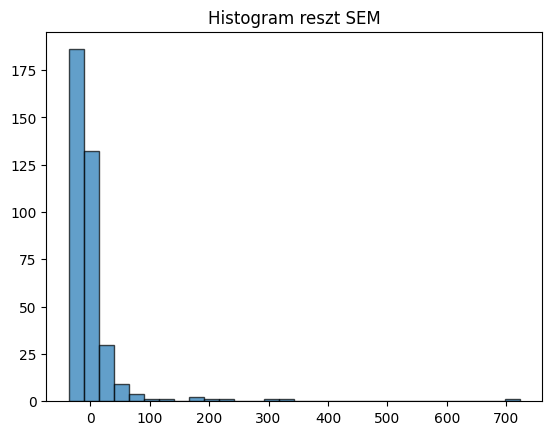

In [ ]:
plt.hist(sem_model.u, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram reszt SEM')
plt.show()
